# **Redes Recurrentes**


In [2]:
#import libreries

import tensorflow as tf
import numpy as np
import pandas as pd
import datasets 
import matplotlib.pyplot as plt

import keras 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# -- Keras Import
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing import image

from keras.datasets import imdb
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Bidirectional, LSTM, GRU, SimpleRNN

from keras.layers import Activation, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import TextVectorization
from gensim.parsing.porter import PorterStemmer 
from gensim.parsing.preprocessing import remove_stopwords
import re
from keras.preprocessing.text import Tokenizer

In [3]:
max_features = 20000
maxlen = 100  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print("Loading data...")

#download data
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   

# Read data
df = dataset['train'].to_pandas()

df.head()


Loading data...


Using custom data configuration ucberkeley-dlab--measuring-hate-speech-7a847a2ec289eb57
Reusing dataset parquet (/Users/karin/.cache/huggingface/datasets/ucberkeley-dlab___parquet/ucberkeley-dlab--measuring-hate-speech-7a847a2ec289eb57/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False


In [4]:
df.columns.to_list()

['comment_id',
 'annotator_id',
 'platform',
 'sentiment',
 'respect',
 'insult',
 'humiliate',
 'status',
 'dehumanize',
 'violence',
 'genocide',
 'attack_defend',
 'hatespeech',
 'hate_speech_score',
 'text',
 'infitms',
 'outfitms',
 'annotator_severity',
 'std_err',
 'annotator_infitms',
 'annotator_outfitms',
 'hypothesis',
 'target_race_asian',
 'target_race_black',
 'target_race_latinx',
 'target_race_middle_eastern',
 'target_race_native_american',
 'target_race_pacific_islander',
 'target_race_white',
 'target_race_other',
 'target_race',
 'target_religion_atheist',
 'target_religion_buddhist',
 'target_religion_christian',
 'target_religion_hindu',
 'target_religion_jewish',
 'target_religion_mormon',
 'target_religion_muslim',
 'target_religion_other',
 'target_religion',
 'target_origin_immigrant',
 'target_origin_migrant_worker',
 'target_origin_specific_country',
 'target_origin_undocumented',
 'target_origin_other',
 'target_origin',
 'target_gender_men',
 'target_gende

In [5]:
df.hatespeech.value_counts()

0.0    80624
2.0    46021
1.0     8911
Name: hatespeech, dtype: int64

In [6]:
def preprocessing(document: str) -> list:
    """
    convert text to lowercase
    remove no latin caracters 
    remove punctuation 
    remove extra spaces
    do stemming text
    """
    document = document.lower()
    document = remove_stopwords(document)
    document = re.sub('\n', ' ', document)
    document = re.sub('[^a-zA-Z]|[0-9]', ' ', document)
    document = re.sub('\s+', ' ', document)
    p = PorterStemmer()
    document = p.stem_sentence(document)
    return document

In [7]:
df['text']=df.text.apply(preprocessing)

In [8]:
X = df[['comment_id',
'annotator_id',
'platform',
'sentiment',
'respect',
'insult',
'humiliate',
'status',
'dehumanize',
'violence',
'genocide',
'attack_defend',
'hatespeech',
'hate_speech_score',
'text',
'infitms',
'outfitms',
'annotator_severity',
'std_err',
'annotator_infitms',
'annotator_outfitms',
'hypothesis',
'target_race_asian',
'target_race_black',
'target_race_latinx',
'target_race_middle_eastern',
'target_race_native_american',
'target_race_pacific_islander',
'target_race_white',
'target_race_other',
'target_race',
'target_religion_atheist',
'target_religion_buddhist',
'target_religion_christian',
'target_religion_hindu',
'target_religion_jewish',
'target_religion_mormon',
'target_religion_muslim',
'target_religion_other',
'target_religion',
'target_origin_immigrant',
'target_origin_migrant_worker',
'target_origin_specific_country',
'target_origin_undocumented',
'target_origin_other',
'target_origin',
'target_gender_men',
'target_gender_non_binary',
'target_gender_transgender_men',
'target_gender_transgender_unspecified',
'target_gender_transgender_women',
'target_gender_women',
'target_gender_other',
'target_gender',
'target_sexuality_bisexual',
'target_sexuality_gay',
'target_sexuality_lesbian',
'target_sexuality_straight',
'target_sexuality_other',
'target_sexuality',
'target_age_children',
'target_age_teenagers',
'target_age_young_adults',
'target_age_middle_aged',
'target_age_seniors',
'target_age_other',
'target_age',
'target_disability_physical',
'target_disability_cognitive',
'target_disability_neurological',
'target_disability_visually_impaired',
'target_disability_hearing_impaired',
'target_disability_unspecific',
'target_disability_other',
'target_disability',
'annotator_gender',
'annotator_trans',
'annotator_educ',
'annotator_income',
'annotator_ideology',
'annotator_gender_men',
'annotator_gender_women',
'annotator_gender_non_binary',
'annotator_gender_prefer_not_to_say',
'annotator_gender_self_describe',
'annotator_transgender',
'annotator_cisgender',
'annotator_transgender_prefer_not_to_say',
'annotator_education_some_high_school',
'annotator_education_high_school_grad',
'annotator_education_some_college',
'annotator_education_college_grad_aa',
'annotator_education_college_grad_ba',
'annotator_education_professional_degree',
'annotator_education_masters',
'annotator_education_phd',
'annotator_income_<10k',
'annotator_income_10k-50k',
'annotator_income_50k-100k',
'annotator_income_100k-200k',
'annotator_income_>200k',
'annotator_ideology_extremeley_conservative',
'annotator_ideology_conservative',
'annotator_ideology_slightly_conservative',
'annotator_ideology_neutral',
'annotator_ideology_slightly_liberal',
'annotator_ideology_liberal',
'annotator_ideology_extremeley_liberal',
'annotator_ideology_no_opinion',
'annotator_race_asian',
'annotator_race_black',
'annotator_race_latinx',
'annotator_race_middle_eastern',
'annotator_race_native_american',
'annotator_race_pacific_islander',
'annotator_race_white',
'annotator_race_other',
'annotator_age',
'annotator_religion_atheist',
'annotator_religion_buddhist',
'annotator_religion_christian',
'annotator_religion_hindu',
'annotator_religion_jewish',
'annotator_religion_mormon',
'annotator_religion_muslim',
'annotator_religion_nothing',
'annotator_religion_other',
'annotator_sexuality_bisexual',
'annotator_sexuality_gay',
'annotator_sexuality_straight',
'annotator_sexuality_other']]

y = df.hatespeech

In [9]:
X = df['text']

### **Replace hatespeech == 1 with 2** 

In [10]:
# replace 1 with 2 in y
y = [1 if x==2 else x for x in y]

In [11]:
y = np.array(y)

### **Split in train and test data** 

In [12]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X,y,
                                                    random_state=1,test_size=0.3)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, 
                                                    y_train_validation, 
                                                    random_state=1,test_size=0.33)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(len(X_train)))
print('Number of rows in the validation set: {}'.format(len(X_validation)))
print('Number of rows in the test set: {}'.format(len(X_test)))

Number of rows in the total set: 135556
Number of rows in the training set: 63575
Number of rows in the validation set: 31314
Number of rows in the test set: 40667


In [13]:
from keras_preprocessing import sequence

max_words = 20000
max_len = 150

word_token = Tokenizer(num_words=max_words)
word_token.fit_on_texts(X_train)
sequences = word_token.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [14]:
sequences_matrix.shape[0]

63575

In [15]:
#def RNN():
#    from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
#    from keras.models import Model
#    inputs = Input(name='inputs',shape=[max_len])
#    layer = Embedding(max_words,50,input_length=max_len)(inputs)
#    layer = LSTM(128)(layer)
#    layer = Dense(256,name='FC1')(layer)
#    layer = Activation('relu')(layer)
#    layer = Dropout(0.5)(layer)
#    layer = Dense(1,name='out_layer')(layer)
#    layer = Activation('sigmoid')(layer)
#    model = Model(inputs=inputs,outputs=layer)
#    return model

In [16]:
print('Build model...')

from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding

max_features = 20000
maxlen = 150 
batch_size = 32


model = Sequential()
model.add(Embedding(max_features, batch_size, input_length=maxlen))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(1))
model.add(Activation('sigmoid'))

Build model...
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-26 21:31:02.713549: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-26 21:31:02.715808: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
from tensorflow.keras.optimizers import RMSprop,Adam

#model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 32)           640000    
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 730,753
Trainable params: 730,753
Non-trai

In [18]:
history = model.fit(sequences_matrix,y_train,batch_size=32,epochs=10,validation_split=0.2)

Epoch 1/10


2022-07-26 21:31:03.892464: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-26 21:31:05.219080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-26 21:31:05.832069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-26 21:31:06.509798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1590/1590 [==============================] - ETA: 0s - loss: 0.4633 - accuracy: 0.7854

2022-07-26 21:32:28.531568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-26 21:32:28.638025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1590/1590 [==============================] - 93s 57ms/step - loss: 0.4633 - accuracy: 0.7854 - val_loss: 0.4424 - val_accuracy: 0.7984
Epoch 2/10
1590/1590 [==============================] - 95s 60ms/step - loss: 0.4263 - accuracy: 0.8070 - val_loss: 0.4432 - val_accuracy: 0.8054
Epoch 3/10
1590/1590 [==============================] - 106s 67ms/step - loss: 0.4179 - accuracy: 0.8128 - val_loss: 0.4344 - val_accuracy: 0.8053
Epoch 4/10
1590/1590 [==============================] - 128s 80ms/step - loss: 0.4135 - accuracy: 0.8152 - val_loss: 0.4340 - val_accuracy: 0.8069
Epoch 5/10
1590/1590 [==============================] - 133s 83ms/step - loss: 0.4093 - accuracy: 0.8201 - val_loss: 0.4293 - val_accuracy: 0.8051
Epoch 6/10
1590/1590 [==============================] - 105s 66ms/step - loss: 0.3991 - accuracy: 0.8252 - val_loss: 0.4383 - val_accuracy: 0.8002
Epoch 7/10
1590/1590 [==============================] - 101s 63ms/step - loss: 0.3913 - accuracy: 0.8314 - val_loss: 0.4431 - val_a

In [19]:
test_sequences = word_token.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [20]:
accr = model.evaluate(test_sequences_matrix,y_test)

1271/1271 [==============================] - 31s 24ms/step - loss: 0.4370 - accuracy: 0.7964


In [21]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.437
  Accuracy: 0.796


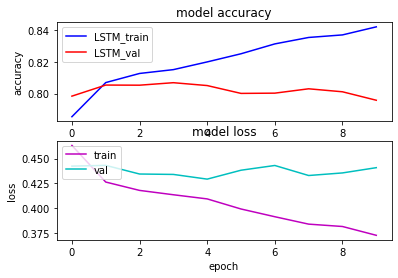

In [22]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

Persistencia del modelo:

In [23]:
model.save('salida/RNN_model')

2022-07-26 21:49:24.787157: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: salida/RNN_model/assets


INFO:tensorflow:Assets written to: salida/RNN_model/assets
